# Home Energy Management with Spot Market and Tiered Peak Power Costs

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm
import itertools

# Custom utility functions
from utils import latexify

## Problem data

In [2]:
# Load data
load_data = pd.read_pickle("data/load_data.pickle")
load_min = load_data.min()
load_max = load_data.max()

# Fixed price data
fixed_price_data = pd.read_pickle("data/fixed_price_data.pickle")

# Spot price data
spot_prices_2020_2022 = pd.read_pickle("data/spot_price_data.pickle")
spot_prices_jan2023 = pd.read_pickle("data/spot_price_data_jan2023.pickle")
spot_price_data = pd.concat([spot_prices_2020_2022, spot_prices_jan2023])

# Load forecasting data
load_baseline = pd.read_pickle("data/load_baseline.pickle")
train_residual = pd.read_pickle("data/train_residual.pickle")
AR_params = pd.read_pickle("data/AR_params.pickle")

# Spot price forecasting data
spot_price_baseline = pd.read_pickle("data/spot_price_baseline.pickle")

# Define simulation window: one year with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")

sim_start_time = load_baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_index = load_data.index[sim_start_time:sim_end_time]

# Load and price data for the simulation window
load = load_data.iloc[sim_start_time:sim_end_time].values
fixed_prices = fixed_price_data.iloc[sim_start_time:sim_end_time].values
spot_prices = spot_price_data.iloc[sim_start_time:sim_end_time].values

## Functions to plot and print results

In [3]:
def compute_monthly_fixed_cost(fixed_prices, power, sim_index):
    monthly_fixed_cost = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_cost = np.sum(fixed_prices[month_mask] * power[month_mask])
        monthly_fixed_cost.append(month_cost)
    return monthly_fixed_cost

def compute_monthly_spot_cost(spot_prices, power, sim_index):
    monthly_spot_cost = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_cost = np.sum(spot_prices[month_mask] * power[month_mask])
        monthly_spot_cost.append(month_cost)
    return monthly_spot_cost

def compute_monthly_peak_cost(power, sim_index):
    def tiered_cost(z):
        if 0 <= z <= 2:
            return 83
        elif 2 < z <= 5:
            return 147
        elif 5 < z <= 10:
            return 252
        elif 10 < z <= 15:
            return 371
        else:
            return 490
    monthly_peak_cost = []
    for k in range(12):
        month_mask = sim_index.month == k + 1
        month_length = sum(month_mask)
        daily_peak_powers = [power[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        top_3_daily_peaks = sorted(daily_peak_powers, reverse=True)[:3]
        average_top_3_peaks = sum(top_3_daily_peaks) / 3
        monthly_peak_cost.append(tiered_cost(average_top_3_peaks))
    return monthly_peak_cost

def compute_annual_cost(spot_prices, fixed_prices, power, sim_index):
    monthly_fixed_cost = compute_monthly_fixed_cost(fixed_prices, power, sim_index)
    monthly_spot_cost = compute_monthly_spot_cost(spot_prices, power, sim_index)
    monthly_peak_cost = compute_monthly_peak_cost(power, sim_index)
    
    annual_cost = sum(monthly_fixed_cost) + sum(monthly_spot_cost) + sum(monthly_peak_cost)
    return annual_cost
    
def print_cost_summary(total_cost, spot_cost, fixed_cost, peak_power_cost):
    print(f"Total cost: {total_cost:,.2f} NOK")
    print(f"Fixed cost: {fixed_cost:,.2f} NOK ({100 * fixed_cost / total_cost:.2f}% of total cost)")
    print(f"Spot market cost: {spot_cost:,.2f} NOK ({100 * spot_cost / total_cost:.2f}% of total cost)")
    print(f"Peak power cost: {peak_power_cost:,.2f} NOK ({100 * peak_power_cost / total_cost:.2f}% of total cost)")
    
# Compute z: monthly average of the largest 3 daily peak powers
def compute_z(power, sim_index):
    z_values = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_length = sum(month_mask)
        daily_peak_powers = [power[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        avg_top_3_peaks = sum(sorted(daily_peak_powers, reverse=True)[:3]) / 3
        z_values.extend([avg_top_3_peaks] * month_length)
    return pd.Series(z_values, index=sim_index)

def plot_monthly_costs(monthly_spot_cost, monthly_fixed_cost, monthly_peak_cost, filename=None, save=False):
    months = range(1, 13)
    latexify(fig_width=6)
    fig, ax = plt.subplots()
    plt.bar(months, monthly_fixed_cost, label='Fixed cost')
    plt.bar(months, monthly_peak_cost, bottom=monthly_fixed_cost, label='Peak power cost')
    plt.bar(months, monthly_spot_cost, bottom=[i+j for i,j in zip(monthly_fixed_cost, monthly_peak_cost)], label='Spot market cost')
    plt.xticks(months, [calendar.month_abbr[m] for m in months])
    plt.ylabel('Cost (NOK)')
    plt.legend()

    if save:
        if filename is None:
            raise ValueError("A filename must be provided when 'save' is set to True.")
        plt.savefig(filename)

def customize_monthly_x_axis(ax, interval):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
def plot_grid_power(sim_index, power, filename=None, save=False):
    z = compute_z(power, sim_index)

    latexify(fig_width=6)
    fig, ax = plt.subplots()
    ax.plot(sim_index, power, color="tab:blue", alpha=0.8, label="Power extracted from the grid")
    ax.plot(sim_index, z, color="k", label="Monthly avg. of 3 daily peak powers")
    plt.ylabel("Power (kW)")
    customize_monthly_x_axis(ax, interval=1)
    # legend = plt.legend()

    if save:
        if filename is None:
            raise ValueError("A filename must be provided when 'save' is set to True.")
        plt.savefig(filename)
    
def print_and_plot_costs(spot_prices, fixed_prices, power, sim_index, filename=None, save=False):
    monthly_fixed_cost = compute_monthly_fixed_cost(fixed_prices, power, sim_index)
    monthly_spot_cost = compute_monthly_spot_cost(spot_prices, power, sim_index)
    monthly_peak_cost = compute_monthly_peak_cost(power, sim_index)

    annual_cost = sum(monthly_fixed_cost) + sum(monthly_spot_cost) + sum(monthly_peak_cost)
    annual_spot_cost = sum(monthly_spot_cost)
    annual_fixed_cost = sum(monthly_fixed_cost)
    annual_peak_cost = sum(monthly_peak_cost)

    print_cost_summary(annual_cost, annual_spot_cost, annual_fixed_cost, annual_peak_cost)
    plot_monthly_costs(monthly_spot_cost, monthly_fixed_cost, monthly_peak_cost, filename, save=save)
    
def plot_state_of_charge(sim_index, state_of_charge, filename=None, save=False):
    latexify(fig_width=6)
    fig, ax = plt.subplots()
    ax.plot(sim_index, state_of_charge, color="tab:blue", alpha=0.8)
    plt.ylabel("State of charge (kWh)")
    customize_monthly_x_axis(ax, interval=1)

    if save:
        if filename is None:
            raise ValueError("A filename must be provided when 'save' is set to True.")
        plt.savefig(filename)

## Baseline analysis: no storage

Total cost: 25,037.07 NOK
Fixed cost: 8,676.61 NOK (34.66% of total cost)
Spot market cost: 13,336.45 NOK (53.27% of total cost)
Peak power cost: 3,024.00 NOK (12.08% of total cost)


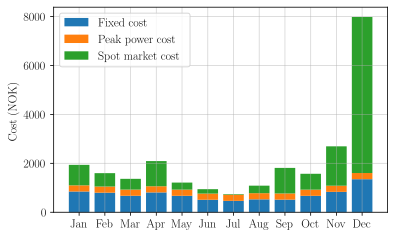

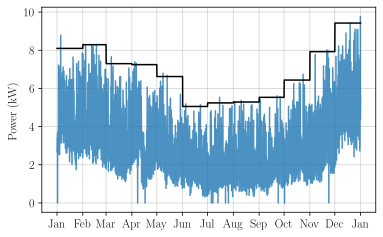

In [4]:
print_and_plot_costs(spot_prices, fixed_prices, load, sim_index)
plot_grid_power(sim_index, load)
cost_no_storage = compute_annual_cost(spot_prices, fixed_prices, load, sim_index)

## Prescient analysis (perfect knowledge of the future)

### MILP formulation

Total cost: 21,801.09 NOK
Fixed cost: 8,137.99 NOK (37.33% of total cost)
Spot market cost: 11,374.11 NOK (52.17% of total cost)
Peak power cost: 2,289.00 NOK (10.50% of total cost)


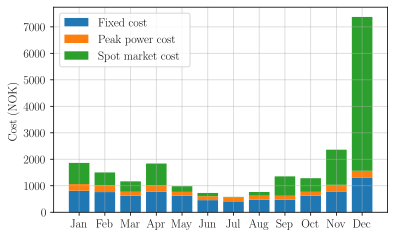

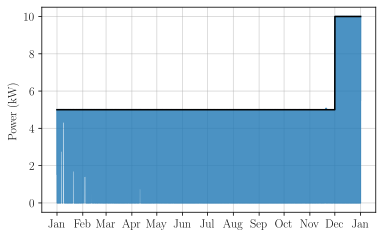

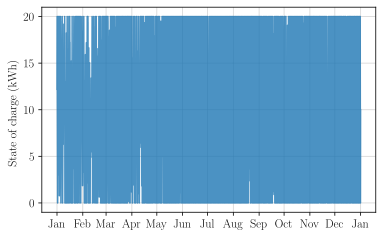

In [8]:
# Constants
storing_efficiency = 1-0.0001
P = 20
T = 24 * 365

# Parameters
Q = cp.Parameter(nonneg=True)
C = cp.Parameter(nonneg=True)
D = cp.Parameter(nonneg=True)
q_init = cp.Parameter(nonneg=True)
q_final = cp.Parameter(nonneg=True)

# Variables
p = cp.Variable(T)  # Grid power
u = cp.Variable(T)  # Battery power
q = cp.Variable(T + 1)  # State of charge

# Constraints
cons = [p >= 0, p <= P,
        load == p + u,
        q[1:] == storing_efficiency * q[:-1] - u,
        q[0] == q_init, q[-1] == q_final,
        q >= 0, q <= Q,
        -C <= u, u <= D]

fixed_cost = cp.sum(cp.multiply(fixed_prices, p))
spot_cost = cp.sum(cp.multiply(spot_prices, p))

K = 12
month_masks = [(sim_index.month == k + 1) for k in range(K)]

tier_costs = np.array([83, 147, 252, 371, 490])
tier_ub = np.array([2, 5, 10, 15, P])
peak_cost = 0

for k in range(K):
    month_mask = month_masks[k]
    p_month = p[month_mask]
    month_length = sum(month_mask)
    p_daily_max = [cp.max(p_month[i:i+24]) for i in range(0, month_length, 24)]
    z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)

    tier_indicator = cp.Variable(5, boolean=True)
    cons.append(z <= cp.matmul(tier_ub, tier_indicator))
    peak_cost += cp.matmul(tier_costs, tier_indicator)

# Total cost
cost = (fixed_cost + spot_cost + peak_cost)

# Create optimization problem
problem = cp.Problem(cp.Minimize(cost), cons)

# Set parameter values
Q.value = 20
C.value = Q.value / 2
D.value = Q.value / 2
q_init.value = Q.value / 2
q_final.value = Q.value / 2

# Solve the problem
problem.solve(solver=cp.MOSEK)

# Report results
print_and_plot_costs(spot_prices, fixed_prices, p.value, sim_index, "figures/cost_prescient_tiered.pdf", save=True)
plot_grid_power(sim_index, p.value, "figures/grid_power_prescient_tiered.pdf", save=True)
plot_state_of_charge(sim_index, q.value[1:], "figures/soc_prescient_tiered.pdf", save=True)
cost_prescient = compute_annual_cost(spot_prices, fixed_prices, p.value, sim_index)

### Relax-resolve strategy

In [ ]:
def get_tier_ub(z):
    if 0 <= z <= 2:
        return 2
    elif 2 < z <= 5:
        return 5
    elif 5 < z <= 10:
        return 10
    elif 10 < z <= 15:
        return 15
    else:
        return P

def create_problem(Q, T, load, fixed_prices, spot_prices, sim_index, relax_mode=True):
    # Constants
    storing_efficiency = 1 - 0.0001
    P = 20
    C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2

    # Variables
    p = cp.Variable(T)  # Grid power
    u = cp.Variable(T)  # Battery power
    q = cp.Variable(T+1)  # State of charge

    # Constraints
    cons = [p >= 0, p <= P,
            load == p + u,
            q[1:] == storing_efficiency * q[:-1] - u,
            q[0] == q_init, q[-1] == q_final,
            q >= 0, q <= Q,
            -C <= u, u <= D]

    fixed_cost = cp.sum(cp.multiply(fixed_prices, p))
    spot_cost = cp.sum(cp.multiply(spot_prices, p))

    K = 12
    month_masks = [(sim_index.month == k + 1) for k in range(K)]
    peak_cost = 0
    z_values = []

    for k in range(K):
        month_mask = month_masks[k]
        p_month = p[month_mask]
        month_length = sum(month_mask)
        p_daily_max = [cp.max(p_month[i:i + 24]) for i in range(0, month_length, 24)]
        z = 1 / 3 * cp.sum_largest(cp.hstack(p_daily_max), 3)
        z_values.append(z)

        if relax_mode:
            peak_cost += cp.maximum(83, cp.maximum(21.33 * (z - 2) + 83, 23.8 * (z - 10) + 252))
        else:
            cons.append(z <= z_ub_values[k])

    # Total cost
    cost = fixed_cost + spot_cost + (peak_cost if relax_mode else 0)

    # Create optimization problem
    problem = cp.Problem(cp.Minimize(cost), cons)

    return problem, p, q, z_values


def relax(Q):
    problem, p, q, z_values = create_problem(Q, T, load, fixed_prices, spot_prices, sim_index)
    problem.solve()

    z_relax = [z.value for z in z_values]

    return [get_tier_ub(z) for z in z_relax]


def resolve(Q, z_ub_values):
    problem, p, q, z_values = create_problem(Q, T, load, fixed_prices, spot_prices, sim_index, relax_mode=False)
    problem.solve()

    return p.value, q.value

Q = 20
z_ub_values = relax(Q)
p_values, q_values = resolve(Q, z_ub_values)

# Report results
print_and_plot_costs(spot_prices, fixed_prices, p_values, sim_index)
plot_grid_power(sim_index, p_values)
plot_state_of_charge(sim_index, q_values[1:])
cost_prescient = compute_annual_cost(spot_prices, fixed_prices, p_values, sim_index)

## Cost versus storage capacity

Performing sensitivity analysis: 100%|██████████| 50/50 [10:09<00:00, 12.18s/it]


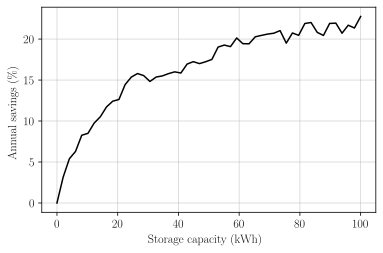

In [6]:
storage_capacities = np.linspace(0, 100)
cost_values = np.zeros(len(storage_capacities))

for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities), desc="Performing sensitivity analysis"):
    Q.value = capacity
    C.value = Q.value / 2
    D.value = Q.value / 2
    q_init.value = Q.value / 2
    q_final.value = Q.value / 2

    # Solve the problem
    problem.solve(solver=cp.MOSEK)

    cost_values[i] = compute_annual_cost(spot_prices, fixed_prices, p.value, sim_index)

savings_percentage = (cost_values[0] - cost_values)/cost_values[0] * 100

latexify(fig_width=6)
plt.figure()
plt.plot(storage_capacities, savings_percentage, color="black", linestyle="solid")
plt.xlabel("Storage capacity (kWh)")
plt.ylabel("Annual savings (\%)")
plt.savefig("figures/savings_vs_storage_capacity_tiered.pdf")

## Model predictive control policy with global search

In [ ]:
def get_tier(z):
    if 0 <= z <= 2:
        return 0
    elif 2 < z <= 5:
        return 1
    elif 5 < z <= 10:
        return 2
    elif 10 < z <= 15:
        return 3
    else:
        return 4

tiers = [0, 1, 2, 3, 4]
tier_costs = np.array([83, 147, 252, 371, 490])
tier_ub = np.array([2, 5, 10, 15, P])

In [ ]:
def group_hours_by_day(datetime_index):
    datetime_series = pd.Series(datetime_index)
    grouped_hours = datetime_series.groupby(datetime_series.dt.to_period('D')).indices
    return grouped_hours

def run_mpc(load, spot_prices, fixed_prices, datetime_index, q_init, q_final, z_init, H, peak_cost_values, z_ub_values):
    p = cp.Variable(H) 
    u = cp.Variable(H) 
    q = cp.Variable(H+1)

    cons = [p >= 0, p <= P,
            load == p + u,
            q[1:] == storing_efficiency * q[:-1] - u,
            q[0] == q_init, q[-1] == q_final, 
            q >= 0, q <= Q,
            -C <= u, u <= D]

    fixed_cost = cp.sum(cp.multiply(fixed_prices, p))
    spot_cost = cp.sum(cp.multiply(spot_prices, p))
    
    # Compute peak cost
    peak_cost = 0
    month_indices = datetime_index.month.unique()
    
    for i, month in enumerate(month_indices):
        month_mask = (pd.Series(datetime_index).dt.month == month)
        month_length = sum(month_mask)
        p_month = p[month_mask]
        z = cp.max(p_month)
        cons.append(z <= z_ub_values[i])
        peak_cost += cp.pos(peak_cost_values[i] - tier_costs[get_tier(z_init)]) if i==0 else peak_cost_values[i]
    
    cost = spot_cost + fixed_cost + peak_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve()

    return u.value[0], p.value[0], cost.value

def update_z(p_values, sim_index):
    last_month = pd.Series(sim_index).dt.to_period('M').iloc[-1]
    month_mask = (pd.Series(sim_index).dt.to_period('M') == last_month)
    p_month = p_values[month_mask]
    month_hours = pd.Series(sim_index)[month_mask]
    daily_hours_grouped = group_hours_by_day(month_hours)
    p_daily_max = [np.max(p_month[hour_indices]) for hour_indices in daily_hours_grouped.values()]
    
    if p_month.shape[0] >= 24*3:
        z = 1/3 * np.sum(np.sort(p_daily_max)[-3:])
    else:
        z = np.max(p_month)
    return z

def predict_load(load, baseline, AR_params, t, M, L):
    past = load[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ AR_params
    
    pred = pd.Series(pred, index=fut_baseline.index)
    pred += fut_baseline
    pred = np.maximum(load_min, pred)
    pred = np.minimum(load_max, pred)
    return pred

def make_load_forecast(t, H, M, L):
    curr_load = np.array([load_data[sim_start_time + t]])
    baseline_AR_forecast = predict_load(load_data, load_baseline, AR_params, sim_start_time+t+1, M, L)[:H-1]

    if H > L:
        baseline_forecast = load_baseline[sim_start_time+t+1+L:sim_start_time+t+H]
    else:
        baseline_forecast = np.array([])

    load_forecast = np.concatenate((curr_load, baseline_AR_forecast, baseline_forecast))
    return load_forecast


def make_spot_price_forecast(t, H):
    # Determine hours with known prices
    if sim_index[t].hour < 13:
        hours_with_known_prices = 24 - sim_index[t].hour
    else:
        hours_with_known_prices = (24-sim_index[t].hour) + 24
    # Create forecast
    if hours_with_known_prices > H:
        spot_price_forecast = spot_price_data[sim_start_time+t:sim_start_time+t+H].values
    else:
        spot_price_forecast = np.concatenate((spot_price_data[sim_start_time+t:sim_start_time+t+hours_with_known_prices].values, spot_price_baseline[sim_start_time+t+hours_with_known_prices:sim_start_time+t+H]))
    return spot_price_forecast

In [ ]:
# # Constants
# Q = 20
# C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
# H = 24
# M, L = 24, 24

# T = 24*365
# sim_index = load_data.index[sim_start_time:sim_start_time+T]

# tier_costs = np.array([83, 147, 252, 371, 490])
# tier_ub = np.array([2, 5, 10, 15, P])

# p_values = np.zeros(T)
# q_values = np.zeros(T+1)
# z_values = np.zeros(T+1)

# # Initial conditions
# q_values[0] = q_init
# z = 0

# t = 0

# def get_tier(z):
#     if 0 <= z <= 2:
#         return 0
#     elif 2 < z <= 5:
#         return 1
#     elif 5 < z <= 10:
#         return 2
#     elif 10 < z <= 15:
#         return 3
#     else:
#         return 4

# # Make forecasts
# load_forecast = make_load_forecast(t, H, M, L)
# spot_price_forecast = make_spot_price_forecast(t, H)
# fixed_price_forecast = fixed_price_data[sim_start_time+t:sim_start_time+t+H].values
# datetime_index = load_baseline.index[sim_start_time+t:sim_start_time+t+H]

# # Number of unique months in planning horizon
# n_months = datetime_index.to_period('M').nunique()

# # Compute all possible tier combinations
# tiers = [1, 2]
# combinations = list(itertools.product(tiers, repeat=n_months))

# # Filter out combinations where the tier in the first month is less than the tier in the current month
# tier_curr = get_tier(z)
# combinations = [comb for comb in combinations if comb[0] >= tier_curr]

# least_cost = np.inf
# u = None
# p = None
# for combo in combinations:
#     peak_cost_values = np.array([tier_costs[c] for c in combo])
#     z_ub_values = np.array([tier_ub[c] for c in combo])

#     try:
#         u, p, cost = run_mpc(load_forecast, spot_price_forecast, fixed_price_forecast, datetime_index, q_values[t], q_final, z, H, peak_cost_values, z_ub_values)

#         if cost < least_cost:
#             least_cost = cost
#             u = u
#             p = p
#     except:
#         continue

In [ ]:
# Constants
Q = 20
C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
H = 24
M, L = 24, 24

T = 24*365
sim_index = load_data.index[sim_start_time:sim_start_time+T]

p_values = np.zeros(T)
q_values = np.zeros(T+1)
z_values = np.zeros(T+1)

# Initial conditions
q_values[0] = q_init
z = 0

# MPC loop
for t in tqdm.trange(T):
    # Make forecasts
    load_forecast = make_load_forecast(t, H, M, L)
    spot_price_forecast = make_spot_price_forecast(t, H)
    fixed_price_forecast = fixed_price_data[sim_start_time+t:sim_start_time+t+H].values
    datetime_index = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    
    # Number of unique months in planning horizon
    n_months = datetime_index.to_period('M').nunique()
    
    # Compute all possible tier combinations
    combinations = list(itertools.product(tiers, repeat=n_months))

    # Filter out combinations where the tier in the first month is less than the tier in the current month
    tier_curr = get_tier(z)
    combinations = [comb for comb in combinations if comb[0] >= tier_curr]
    
    # Global search across all possible tier combinations
    least_cost = np.inf
    u = None
    p = None
    for combo in combinations:
        peak_cost_values = np.array([tier_costs[c] for c in combo])
        z_ub_values = np.array([tier_ub[c] for c in combo])

        try:
            u, p, cost = run_mpc(load_forecast, spot_price_forecast, fixed_price_forecast, datetime_index, q_values[t], q_final, z, H, peak_cost_values, z_ub_values)

            if cost < least_cost:
                least_cost = cost
                u = u
                p = p
        except:
            continue

    # Execute first action
    p_values[t] = p
    q_values[t+1] = storing_efficiency * q_values[t] - u
    if load_baseline.index[t].month == load_baseline.index[t+1].month:
        z = update_z(p_values[:t+1], sim_index[:t+1])
    else:
        z = 0

In [ ]:
print_and_plot_costs(spot_prices, fixed_prices, p_values, sim_index, filename="figures/cost_mpc_tiered.pdf", save=True)
plot_grid_power(sim_index, p_values, filename="figures/grid_power_mpc_tiered.pdf", save=True)
plot_state_of_charge(sim_index, q_values[1:], filename="figures/soc_mpc_tiered.pdf", save=True)
cost_mpc = compute_annual_cost(spot_prices, fixed_prices, p_values, sim_index)

## Cost comparison

In [ ]:
print(f"Cost without storage: {cost_no_storage:,.2f} NOK")
print(f"Prescient cost with 20 kWh of storage capacity: {cost_prescient:,.2f} NOK")
print(f"MPC cost with 20 kWh of storage capacity: {cost_mpc:,.2f} NOK")

relative_gap = (abs(cost_mpc - cost_prescient) / abs(cost_prescient)) * 100
print(f"Relative gap between MPC cost and prescient cost: {relative_gap:.2f}%")
print(f"Annual savings with MPC policy and 20 kWh of storage capacity: {cost_no_storage-cost_mpc:.2f} NOK ({100 * (cost_no_storage-cost_mpc) / cost_no_storage:.2f}%)")